<a href="https://colab.research.google.com/github/yfb2022/STAT_DL_INTRO/blob/main/3_6_classifying_newswires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

'2.15.0'

# Classifying newswires: a multi-class classification example

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network.
But what happens when you have more than two classes?

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

이전 섹션에서는 신경망을 사용하여 벡터 입력을 상호 배타적인 두 클래스로 분류하는 방법을 살펴보았습니다. 하지만 클래스가 두 개 이상 있으면 어떻게 되나요?

이 섹션에서는 Reuters 뉴스를 46개의 상호 배타적인 주제로 분류하는 네트워크를 구축할 것입니다. 클래스가 많기 때문에 이 문제는 "다중 클래스 분류"의 예이고, 각 데이터 포인트가 하나의 범주로만 분류되어야 하므로 이 문제는 보다 구체적으로 "단일 레이블, 다중 클래스 분류"의 예입니다. 각 데이터 포인트가 여러 범주(이 경우 주제)에 속할 수 있다면 "다중 레이블, 다중 클래스 분류" 문제에 직면하게 됩니다.

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple,
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2110848/2110848 [==============================] - 0s 0us/step



Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the
data.

We have 8,982 training examples and 2,246 test examples:

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [6]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [7]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

550378/550378 [==============================] - 0s 0us/step


In [8]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [9]:
train_labels[10]

3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [10]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot"
encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding".
For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1.
In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

레이블을 벡터화하려면 두 가지 CASE가 있습니다. 레이블 목록을 정수 텐서로 캐스팅하거나 "원-핫" 인코딩을 사용할 수 있습니다. 원-핫 인코딩은 "범주형 인코딩"이라고도 하는 범주형 데이터에 널리 사용되는 형식입니다.

In [11]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [13]:
from keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network


This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to
classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the
dimensionality of the output space is much larger.

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer.
If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each
layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a
16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks,
permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

이 주제 분류 문제는 이전 영화 리뷰 분류 문제와 매우 유사해 보입니다. 두 경우 모두 짧은 텍스트 조각을 분류하려고 합니다. 그러나 여기에는 새로운 제약이 있습니다. 출력 클래스의 수가 2에서 46으로 늘어났습니다. 즉, 출력 공간의 차원이 훨씬 더 커졌습니다.

우리가 사용했던 것과 같은 레이어 스택에서 Dense각 레이어는 이전 레이어의 출력에 있는 정보에만 액세스할 수 있습니다. 한 레이어에서 분류 문제와 관련된 일부 정보를 삭제하면 이 정보는 이후 레이어에서 결코 복구할 수 없습니다. 각 레이어는 잠재적으로 "정보 병목 현상"이 될 수 있습니다. 이전 예에서는 16차원 중간 레이어를 사용했지만 16차원 공간은 46개의 서로 다른 클래스를 분리하는 방법을 학습하기에는 너무 제한적일 수 있습니다. 이러한 작은 레이어는 정보 병목 현상으로 작용하여 관련 정보를 영구적으로 삭제할 수 있습니다.


In [14]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))


There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions:
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the
distance between these two distributions, we train our network to output something as close as possible to the true labels.

이 아키텍처에 대해 주목해야 할 두 가지 다른 사항이 있습니다.

우리는 크기가 46인 레이어로 네트워크를 종료합니다. Dense이는 각 입력 샘플에 대해 네트워크가 46차원 벡터를 출력한다는 것을 의미합니다. 이 벡터의 각 항목(각 차원)은 서로 다른 출력 클래스를 인코딩합니다.

마지막 레이어는 softmax활성화를 사용합니다. MNIST 예제에서 이 패턴을 이미 본 적이 있습니다. 이는 네트워크가 46개의 서로 다른 출력 클래스에 대한 확률 분포를output[i] 출력한다는 것을 의미합니다. 즉, 모든 입력 샘플에 대해 네트워크는 샘플이 i 클래스에 속할 확률인 46차원 출력 벡터를 생성합니다. 46개 점수의 합은 1이 됩니다.

이 경우에 사용하기 가장 좋은 손실 함수는 입니다 categorical_crossentropy. 이는 두 확률 분포 사이의 거리를 측정합니다. 이 경우에는 네트워크에서 출력된 확률 분포와 레이블의 실제 분포 사이를 측정합니다. 이 두 분포 사이의 거리를 최소화함으로써 우리는 실제 레이블에 가능한 한 가까운 것을 출력하도록 네트워크를 훈련시킵니다.

In [15]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [16]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [17]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 74ms/step - loss: 2.7668 - accuracy: 0.4634 - val_loss: 1.8858 - val_accuracy: 0.5960
Epoch 2/20
16/16 [==============================] - 1s 51ms/step - loss: 1.5557 - accuracy: 0.6760 - val_loss: 1.3881 - val_accuracy: 0.6840
Epoch 3/20
16/16 [==============================] - 1s 87ms/step - loss: 1.1853 - accuracy: 0.7446 - val_loss: 1.1977 - val_accuracy: 0.7360
Epoch 4/20
16/16 [==============================] - 1s 79ms/step - loss: 0.9690 - accuracy: 0.7908 - val_loss: 1.0821 - val_accuracy: 0.7690
Epoch 5/20
16/16 [==============================] - 1s 61ms/step - loss: 0.7984 - accuracy: 0.8255 - val_loss: 1.0127 - val_accuracy: 0.7920
Epoch 6/20
16/16 [==============================] - 1s 49ms/step - loss: 0.6713 - accuracy: 0.8518 - val_loss: 0.9451 - val_accuracy: 0.8040
Epoch 7/20
16/16 [==============================] - 1s 75ms/step - loss: 0.5612 - accuracy: 0.8829 - val_loss: 0.9085 - val_accuracy: 0.8150
Epoch 8/20
16

Let's display its loss and accuracy curves:

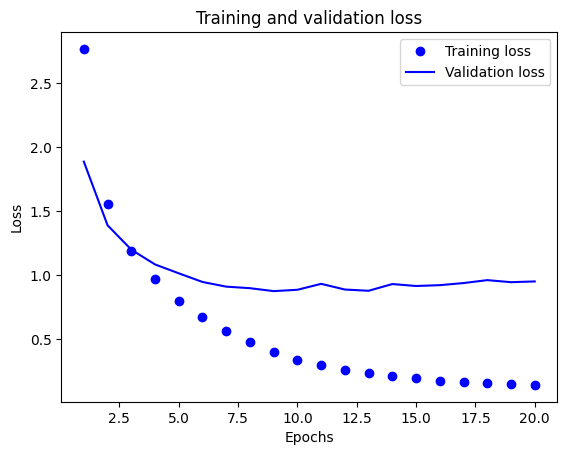

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

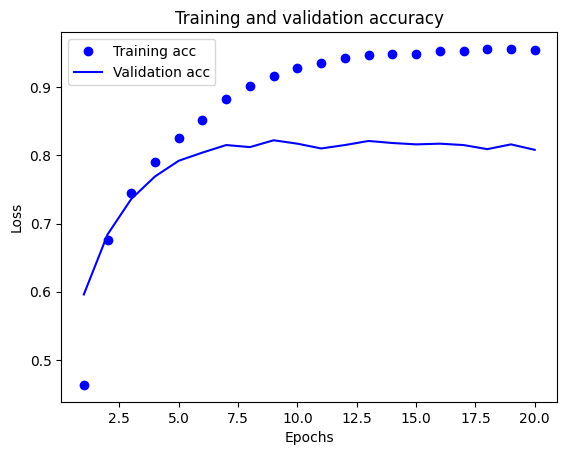

In [23]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs. Let's train a new network from scratch for 8 epochs, then let's evaluate it on
the test set:

In [24]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/8
16/16 [==============================] - 2s 69ms/step - loss: 2.6808 - accuracy: 0.5103 - val_loss: 1.8454 - val_accuracy: 0.6210
Epoch 2/8
16/16 [==============================] - 1s 52ms/step - loss: 1.5517 - accuracy: 0.6832 - val_loss: 1.3926 - val_accuracy: 0.7050
Epoch 3/8
16/16 [==============================] - 1s 48ms/step - loss: 1.1889 - accuracy: 0.7446 - val_loss: 1.2000 - val_accuracy: 0.7450
Epoch 4/8
16/16 [==============================] - 1s 68ms/step - loss: 0.9757 - accuracy: 0.7888 - val_loss: 1.0985 - val_accuracy: 0.7640
Epoch 5/8
16/16 [==============================] - 1s 88ms/step - loss: 0.8180 - accuracy: 0.8205 - val_loss: 1.0316 - val_accuracy: 0.7750
Epoch 6/8
16/16 [==============================] - 1s 73ms/step - loss: 0.6874 - accuracy: 0.8480 - val_loss: 0.9620 - val_accuracy: 0.8000
Epoch 7/8
16/16 [==============================] - 1s 49ms/step - loss: 0.5794 - accuracy: 0.8751 - val_loss: 0.9234 - val_accuracy: 0.8050
Epoch 8/8
71/71 [===

In [25]:
results

[0.975148618221283, 0.7796081900596619]


Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier
would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

우리의 접근 방식은 ~78%의 정확도에 도달했습니다. 균형 잡힌 이진 분류 문제의 경우 순수 무작위 분류기가 도달한 정확도는 50%이지만 우리의 경우에는 19%에 가까우므로 적어도 무작위 기준과 비교할 때 결과가 꽤 좋아 보입니다.

In [26]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.18388245770258238

## Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. Let's generate topic
predictions for all of the test data:

In [27]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 4ms/step


Each entry in `predictions` is a vector of length 46:

In [28]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [29]:
np.sum(predictions[0])

1.0

The largest entry is the predicted class, i.e. the class with the highest probability:

In [30]:
np.argmax(predictions[0])

3

## A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like such:

In [31]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)


The only thing it would change is the choice of the loss function. Our previous loss, `categorical_crossentropy`, expects the labels to
follow a categorical encoding. With integer labels, we should use `sparse_categorical_crossentropy`: 정수인코딩

In [32]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

This new loss function is still mathematically the same as `categorical_crossentropy`; it just has a different interface.

## On the importance of having sufficiently large intermediate layers


We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden
units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than
46-dimensional, e.g. 4-dimensional.

앞서 우리는 최종 출력이 46차원이었기 때문에 은닉 유닛이 46개보다 훨씬 적은 중간 레이어를 피해야 한다고 언급했습니다.

이제 46차원보다 훨씬 작은 중간 레이어(예: 4차원)를 사용하여 정보 병목 현상을 도입할 때 어떤 일이 발생하는지 살펴보겠습니다.

In [33]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 3s 25ms/step - loss: 2.7830 - accuracy: 0.4037 - val_loss: 2.0265 - val_accuracy: 0.5700
Epoch 2/20
63/63 [==============================] - 1s 17ms/step - loss: 1.7677 - accuracy: 0.5728 - val_loss: 1.6327 - val_accuracy: 0.5770
Epoch 3/20
63/63 [==============================] - 1s 17ms/step - loss: 1.4930 - accuracy: 0.5950 - val_loss: 1.5034 - val_accuracy: 0.6090
Epoch 4/20
63/63 [==============================] - 1s 17ms/step - loss: 1.3433 - accuracy: 0.6299 - val_loss: 1.4399 - val_accuracy: 0.6250
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 1.2370 - accuracy: 0.6585 - val_loss: 1.4063 - val_accuracy: 0.6480
Epoch 6/20
63/63 [==============================] - 1s 17ms/step - loss: 1.1576 - accuracy: 0.6939 - val_loss: 1.3892 - val_accuracy: 0.6620
Epoch 7/20
63/63 [==============================] - 1s 17ms/step - loss: 1.0921 - accuracy: 0.7093 - val_loss: 1.3823 - val_accuracy: 0.6660
Epoch 8/20
63


Our network now seems to peak at ~71% test accuracy, a 8% absolute drop. This drop is mostly due to the fact that we are now trying to
compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is
too low-dimensional. The network is able to cram _most_ of the necessary information into these 8-dimensional representations, but not all
of it.

우리 네트워크는 이제 최대 71%의 테스트 정확도로 최고점에 도달한 것으로 보이며 이는 8%의 절대 하락률입니다. 이러한 감소는 주로 우리가 많은 정보(46개 클래스의 분리 초평면을 복구하기에 충분한 정보)를 너무 낮은 차원의 중간 공간으로 압축하려고 시도하고 있다는 사실에 기인합니다. 네트워크는 필요한 정보의 대부분을 이러한 8차원 표현에 담을 수 있지만 전부는 아닙니다.

## Further experiments (PROJECTS)

* Try using larger or smaller layers: 32 units, 128 units...
* We were using two hidden layers. Now try to use a single hidden layer, or three hidden layers.

## Wrapping up


Here's what you should take away from this example:

* If you are trying to classify data points between N classes, your network should end with a `Dense` layer of size N.
* In a single-label, multi-class classification problem, your network should end with a `softmax` activation, so that it will output a
probability distribution over the N output classes.
* _Categorical crossentropy_ is almost always the loss function you should use for such problems. It minimizes the distance between the
probability distributions output by the network, and the true distribution of the targets.
* There are two ways to handle labels in multi-class classification:
    ** Encoding the labels via "categorical encoding" (also known as "one-hot encoding") and using `categorical_crossentropy` as your loss
function.
    ** Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function.
* If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having
intermediate layers that are too small.

1. N개의 클래스 간에 데이터 포인트를 분류하려는 경우 네트워크는 Dense크기가 N인 레이어 로 끝나야 합니다.
2. 단일 레이블, 다중 클래스 분류 문제에서 네트워크는 softmax N개의 출력 클래스에 대한 확률 분포를 출력하도록 활성화로 끝나야 합니다.
3. 범주형 교차엔트로피는 거의 항상 이러한 문제에 사용해야 하는 손실 함수입니다. 이는 네트워크에서 출력되는 확률 분포와 대상의 실제 분포 사이의 거리를 최소화합니다.
4. 다중 클래스 분류에서 레이블을 처리하는 방법에는 두 가지가 있습니다. ** "범주형 인코딩"("원-핫 인코딩"이라고도 함)을 통해 레이블을 인코딩하고 categorical_crossentropy손실 함수로 사용합니다. ** 레이블을 정수로 인코딩하고 sparse_categorical_crossentropy손실 함수를 사용합니다.
5. 데이터를 많은 범주로 분류해야 하는 경우 중간 계층을 너무 작게 하여 네트워크에 정보 병목 현상이 발생하지 않도록 해야 합니다.